<h1> Visual Recognition Mini Project
<h4> Varsha Yamsani(IMT2022506)<br>
<h4> Keshav Goyal(IMT2022560)<br>
<h4> R Harshavardhan(IMT2022515)

<h3>Task C and D: Mask Region Segmentation</h3>
<h5>In this section, we focus on segmenting mask regions in facial images using both traditional and deep learning-based approaches. First, we implement region-based segmentation techniques such as thresholding and edge detection to identify mask areas. We then train a U-Net model for precise mask segmentation and compare its performance against traditional methods using metrics like IoU and Dice score. Through visualization and evaluation, we aim to determine the most effective approach for accurate mask segmentation.



In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K  # Import Keras backend
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate


<h2>Task C: Region Segmentation Using Traditional Techniques
<h5>This code performs region-based mask segmentation using traditional image processing techniques. It processes each image by converting it to grayscale, applying Gaussian blur to reduce noise, and using Otsu's thresholding for binary segmentation. Morphological closing is applied to refine the mask, and the largest detected contour is extracted using convex hull. The predicted mask is then compared with the ground truth by computing Intersection over Union (IoU) and Dice Score, which measure segmentation accuracy. Finally, the script reports individual and average performance metrics across all images

In [3]:
croppedFolder = "dataset/MSFD/1/face_crop"
groundTruthFolder = "dataset/MSFD/1/face_crop_segmentation"
outputFolder = "segmentationOutputs"
os.makedirs(outputFolder, exist_ok=True)

# Get image paths
imagePaths = glob(os.path.join(croppedFolder, "*.jpg"))
iouScores = []
diceScores = []

In [3]:
for imagePath in imagePaths:
    filename = os.path.basename(imagePath)
    image = cv2.imread(imagePath)
    groundTruthPath = os.path.join(groundTruthFolder, filename)

    if not os.path.exists(groundTruthPath):
        print(f"Warning: Ground truth not found for {filename}, skipping...")
        continue

    ground_truth = cv2.imread(groundTruthPath, cv2.IMREAD_GRAYSCALE)
    if ground_truth is None:
        print(f"Error: Could not load ground truth for {filename}, skipping...")
        continue

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's Thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply Morphological Closing (dilation followed by erosion)
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask
    predictedMask = np.zeros_like(gray)

    if contours:
        # Find the largest contour (assuming it's the object)
        largest_contour = max(contours, key=cv2.contourArea)

        # Use Convex Hull to refine object boundaries
        hull = cv2.convexHull(largest_contour)
        
        # Draw the refined contour
        cv2.drawContours(predictedMask, [hull], -1, (255), thickness=cv2.FILLED)

    # Save the predicted mask
    cv2.imwrite(os.path.join(outputFolder, filename), predictedMask)

    # Resize predicted mask to match ground truth
    predictedMask = cv2.resize(predictedMask, (ground_truth.shape[1], ground_truth.shape[0]))

    # Normalize masks (0 and 1 instead of 0 and 255)
    ground_truth = (ground_truth > 127).astype(np.uint8)
    predictedMask = (predictedMask > 127).astype(np.uint8)

    # Compute IoU
    intersection = np.logical_and(ground_truth, predictedMask).sum()
    union = np.logical_or(ground_truth, predictedMask).sum()
    iou = intersection / union if union != 0 else 0
    iouScores.append(iou)

    # Compute Dice Score
    dice = (2 * intersection) / (ground_truth.sum() + predictedMask.sum()) if (ground_truth.sum() + predictedMask.sum()) != 0 else 0
    diceScores.append(dice)

    print(f"{filename} - IoU: {iou:.4f}, Dice: {dice:.4f}")

# Print Average Scores
print(f"\nAverage IoU: {np.mean(iouScores):.4f}")
print(f"Average Dice Score: {np.mean(diceScores):.4f}")

000000_1.jpg - IoU: 0.8079, Dice: 0.8937
000001_1.jpg - IoU: 0.4174, Dice: 0.5890
000002_1.jpg - IoU: 0.4764, Dice: 0.6454
000003_1.jpg - IoU: 0.4164, Dice: 0.5880
000004_1.jpg - IoU: 0.2011, Dice: 0.3348
000005_1.jpg - IoU: 0.2783, Dice: 0.4355
000006_1.jpg - IoU: 0.3682, Dice: 0.5382
000006_2.jpg - IoU: 0.3744, Dice: 0.5449
000007_1.jpg - IoU: 0.5229, Dice: 0.6867
000007_2.jpg - IoU: 0.4997, Dice: 0.6664
000008_1.jpg - IoU: 0.3183, Dice: 0.4829
000009_1.jpg - IoU: 0.4803, Dice: 0.6490
000010_1.jpg - IoU: 0.4140, Dice: 0.5856
000011_1.jpg - IoU: 0.3056, Dice: 0.4682
000011_2.jpg - IoU: 0.2883, Dice: 0.4476
000011_3.jpg - IoU: 0.1775, Dice: 0.3014
000011_4.jpg - IoU: 0.2438, Dice: 0.3921
000011_5.jpg - IoU: 0.2567, Dice: 0.4085
000011_6.jpg - IoU: 0.3698, Dice: 0.5399
000012_1.jpg - IoU: 0.3805, Dice: 0.5513
000013_1.jpg - IoU: 0.2493, Dice: 0.3991
000013_2.jpg - IoU: 0.1750, Dice: 0.2979
000013_3.jpg - IoU: 0.0049, Dice: 0.0097
000014_1.jpg - IoU: 0.2679, Dice: 0.4226
000014_2.jpg - I

<h3>Example Output with the approach

IoU: 0.3234, Dice: 0.4887


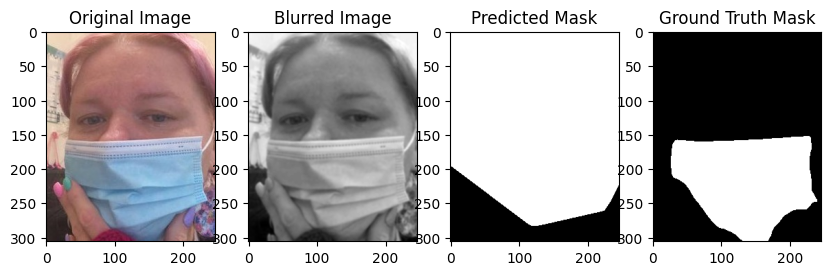

In [ ]:
# /007342_2.jpg
# Load the input image
image_path = "dataset/MSFD/1/face_crop/005626_1.jpg"  # Replace with correct path
ground_truth_path = "dataset/MSFD/1/face_crop_segmentation/005626_1.jpg"  # Replace with correct GT path

image = cv2.imread(image_path)
ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)  # Load GT as grayscale

if ground_truth is None:
    raise FileNotFoundError(f"Ground truth image not found: {ground_truth_path}")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Otsu's Thresholding
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply Morphological Closing (dilation followed by erosion)
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask
predictedMask = np.zeros_like(gray)

if contours:
    # Find the largest contour (assuming it's the object)
    largest_contour = max(contours, key=cv2.contourArea)

    # Use Convex Hull to refine object boundaries
    hull = cv2.convexHull(largest_contour)
    
    # Draw the refined contour
    cv2.drawContours(predictedMask, [hull], -1, (255), thickness=cv2.FILLED)

# Resize predicted mask to match ground truth
predictedMask = cv2.resize(predictedMask, (ground_truth.shape[1], ground_truth.shape[0]))

# Normalize masks (0 and 1 instead of 0 and 255)
ground_truth = (ground_truth > 127).astype(np.uint8)
predictedMask = (predictedMask > 127).astype(np.uint8)

# Compute IoU
intersection = np.logical_and(ground_truth, predictedMask).sum()
union = np.logical_or(ground_truth, predictedMask).sum()
iou = intersection / union if union != 0 else 0
iouScores.append(iou)

# Compute Dice Score
dice = (2 * intersection) / (ground_truth.sum() + predictedMask.sum()) if (ground_truth.sum() + predictedMask.sum()) != 0 else 0
diceScores.append(dice)

print(f"IoU: {iou:.4f}, Dice: {dice:.4f}")
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(blurred, cmap="gray")
plt.title("Blurred Image")

plt.subplot(1, 4, 3)
plt.imshow(predictedMask, cmap="gray")
plt.title("Predicted Mask")

plt.subplot(1, 4, 4)
plt.imshow(ground_truth, cmap="gray")
plt.title("Ground Truth Mask")

plt.show()

<h2>Task D: Mask Segmentation Using U-Net
<h5>This project focuses on face mask detection, classification, and segmentation using deep learning. A U-Net model is trained on a dataset of cropped face images and their corresponding segmentation masks to accurately segment masked and unmasked regions. The model is evaluated using IoU, Dice score, precision, recall, and accuracy to compare performance across different hyperparameter settings. The results help determine the optimal model configuration for accurate face mask segmentation.




<h3> Loading the dataset and splitting it into train test
<h5> preprocessing image and mask data for a U-Net model by ensuring proper tensor formats, adding channel dimensions, converting grayscale images to RGB, binarizing masks, and verifying dataset integrity.

In [4]:
FACE_CROP_DIR = "dataset/MSFD/1/face_crop"
SEGMENTATION_DIR = "dataset/MSFD/1/face_crop_segmentation"

IMG_HEIGHT, IMG_WIDTH = 128, 128

In [5]:

images = []
masks = []

# Get all image filenames in the face_crop directory
for img_name in os.listdir(FACE_CROP_DIR):
    # Construct paths for the input image and corresponding mask
    img_path = os.path.join(FACE_CROP_DIR, img_name)
    mask_path = os.path.join(SEGMENTATION_DIR, img_name)  # Mask filename should match image filename
    
    # Check if both image and mask exist
    if os.path.exists(img_path) and os.path.exists(mask_path):
        # Load and preprocess the input image
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img = img_to_array(img) / 255.0  # Normalize image to [0, 1]
        images.append(img)
        
        # Load and preprocess the mask
        mask = load_img(mask_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH))
        mask = img_to_array(mask) / 255.0  # Normalize mask to [0, 1]
        masks.append(mask)
    else:
        continue

images = np.array(images)
masks = np.array(masks)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Total images: {len(images)}, Total masks: {len(masks)}")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Total images: 9382, Total masks: 9382
Training set: (7505, 128, 128, 3), (7505, 128, 128, 1)
Testing set: (1877, 128, 128, 3), (1877, 128, 128, 1)


In [7]:
y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

# Convert masks to binary using TensorFlow operations
y_train = tf.where(y_train > 0.5, 1.0, 0.0)  # Binarize masks
y_test = tf.where(y_test > 0.5, 1.0, 0.0)  # Binarize masks

# Ensure X_train and X_test have the proper channel dimensions
if len(X_train.shape) == 3:  # If X_train is missing channel dimension
    X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension
    X_test = np.expand_dims(X_test, axis=-1)

if len(y_train.shape) == 3:  # If y_train is missing channel dimension
    y_train = np.expand_dims(y_train, axis=-1)
    y_test = np.expand_dims(y_test, axis=-1)

# Convert grayscale images to RGB if necessary
if X_train.shape[-1] == 1:  # Check if images are grayscale
    X_train = np.repeat(X_train, 3, axis=-1)  # Convert to RGB
    X_test = np.repeat(X_test, 3, axis=-1)

# Convert everything to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Double-check binary conversion and unique values in masks
y_train = tf.where(y_train > 0.5, 1.0, 0.0)
y_test = tf.where(y_test > 0.5, 1.0, 0.0)

# Final verification: Print final dataset shapes and mask values
print(f"Final X_train shape: {X_train.shape}")
print(f"Final y_train shape: {y_train.shape}")
print(f"Unique values in y_train: {np.unique(y_train.numpy())}")
print(f"Unique values in y_test: {np.unique(y_test.numpy())}")


Final X_train shape: (7505, 128, 128, 3)
Final y_train shape: (7505, 128, 128, 1)
Unique values in y_train: [0. 1.]
Unique values in y_test: [0. 1.]


<h3>Defining various metric functions

In [8]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

In [9]:
def dice_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection) / (union + K.epsilon())
    return dice

In [10]:
def precision(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [11]:
def recall(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions
    true_positives = tf.reduce_sum(y_true * y_pred)
    actual_positives = tf.reduce_sum(y_true)
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

In [12]:
def accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions
    correct_predictions = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

<h3>Defining the U-Net Model
<h5>Three different models with various hyperparameters were tested out

In [20]:
# Function to define the U-Net model
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [26]:
# Create U-Net model
modelFirst = unet_model()
# Compile the model with all metrics
modelFirst.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[accuracy, precision, recall, iou_metric, dice_score]
)

# Train the modelFirst
historyFirst = modelFirst.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=16,
    epochs=5,
    verbose=1
)

Epoch 1/5


c:\Users\rog\anaconda3\envs\MLTutorial\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_222']. Received: the structure of inputs=*
  warnings.warn(


376/376 ━━━━━━━━━━━━━━━━━━━━ 1594s 4s/step - accuracy: 0.8413 - dice_score: 0.7067 - iou_metric: 0.5999 - loss: 0.3326 - precision: 0.7527 - recall: 0.7103 - val_accuracy: 0.9446 - val_dice_score: 0.9176 - val_iou_metric: 0.8482 - val_loss: 0.1384 - val_precision: 0.9043 - val_recall: 0.9319
Epoch 2/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 1540s 4s/step - accuracy: 0.9489 - dice_score: 0.9218 - iou_metric: 0.8554 - loss: 0.1271 - precision: 0.9255 - recall: 0.9196 - val_accuracy: 0.9541 - val_dice_score: 0.9332 - val_iou_metric: 0.8752 - val_loss: 0.1171 - val_precision: 0.9007 - val_recall: 0.9686
Epoch 3/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 1424s 4s/step - accuracy: 0.9618 - dice_score: 0.9417 - iou_metric: 0.8902 - loss: 0.0970 - precision: 0.9429 - recall: 0.9417 - val_accuracy: 0.9611 - val_dice_score: 0.9424 - val_iou_metric: 0.8916 - val_loss: 0.1171 - val_precision: 0.9264 - val_recall: 0.9597
Epoch 4/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 1264s 3s/step - accuracy: 0.9692 - dice_score: 0.9528 - iou_me

In [27]:
# Create U-Net model
modelSecond = unet_model()
# Compile the model with all metrics
modelSecond.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[accuracy, precision, recall, iou_metric, dice_score]
)

# Train the modelSecond
historySecond = modelSecond.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=5,
    verbose=1
)

Epoch 1/5


c:\Users\rog\anaconda3\envs\MLTutorial\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_254']. Received: the structure of inputs=*
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 1461s 8s/step - accuracy: 0.7327 - dice_score: 0.4432 - iou_metric: 0.3440 - loss: 0.7090 - precision: 0.5603 - recall: 0.4608 - val_accuracy: 0.9183 - val_dice_score: 0.8720 - val_iou_metric: 0.7734 - val_loss: 0.2007 - val_precision: 0.9091 - val_recall: 0.8383
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1423s 8s/step - accuracy: 0.9241 - dice_score: 0.8826 - iou_metric: 0.7907 - loss: 0.1851 - precision: 0.8919 - recall: 0.8775 - val_accuracy: 0.9455 - val_dice_score: 0.9159 - val_iou_metric: 0.8451 - val_loss: 0.1351 - val_precision: 0.9382 - val_recall: 0.8950
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2470s 13s/step - accuracy: 0.9492 - dice_score: 0.9218 - iou_metric: 0.8552 - loss: 0.1266 - precision: 0.9268 - recall: 0.9180 - val_accuracy: 0.9592 - val_dice_score: 0.9390 - val_iou_metric: 0.8852 - val_loss: 0.1069 - val_precision: 0.9330 - val_recall: 0.9452
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1343s 7s/step - accuracy: 0.9621 - dice_score: 0.9421 - iou_m

In [28]:
# Create U-Net model
modelThird = unet_model()
# Compile the model with all metrics
modelThird.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[accuracy, precision, recall, iou_metric, dice_score]
)

# Train the modelThird
historyThird = modelThird.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=16,
    epochs=5,
    verbose=1
)

Epoch 1/5


c:\Users\rog\anaconda3\envs\MLTutorial\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_286']. Received: the structure of inputs=*
  warnings.warn(


376/376 ━━━━━━━━━━━━━━━━━━━━ 1223s 3s/step - accuracy: 0.7399 - dice_score: 0.5298 - iou_metric: 0.3820 - loss: 0.5655 - precision: 0.6613 - recall: 0.5099 - val_accuracy: 0.8899 - val_dice_score: 0.8334 - val_iou_metric: 0.7152 - val_loss: 0.2517 - val_precision: 0.8365 - val_recall: 0.8327
Epoch 2/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 1287s 3s/step - accuracy: 0.9072 - dice_score: 0.8562 - iou_metric: 0.7505 - loss: 0.2222 - precision: 0.8697 - recall: 0.8499 - val_accuracy: 0.9372 - val_dice_score: 0.9054 - val_iou_metric: 0.8278 - val_loss: 0.1532 - val_precision: 0.9035 - val_recall: 0.9082
Epoch 3/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 1157s 3s/step - accuracy: 0.9450 - dice_score: 0.9157 - iou_metric: 0.8449 - loss: 0.1374 - precision: 0.9208 - recall: 0.9124 - val_accuracy: 0.9622 - val_dice_score: 0.9435 - val_iou_metric: 0.8935 - val_loss: 0.0996 - val_precision: 0.9322 - val_recall: 0.9555
Epoch 4/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 1341s 4s/step - accuracy: 0.9636 - dice_score: 0.9444 - iou_me

<h3>Various Results obtained

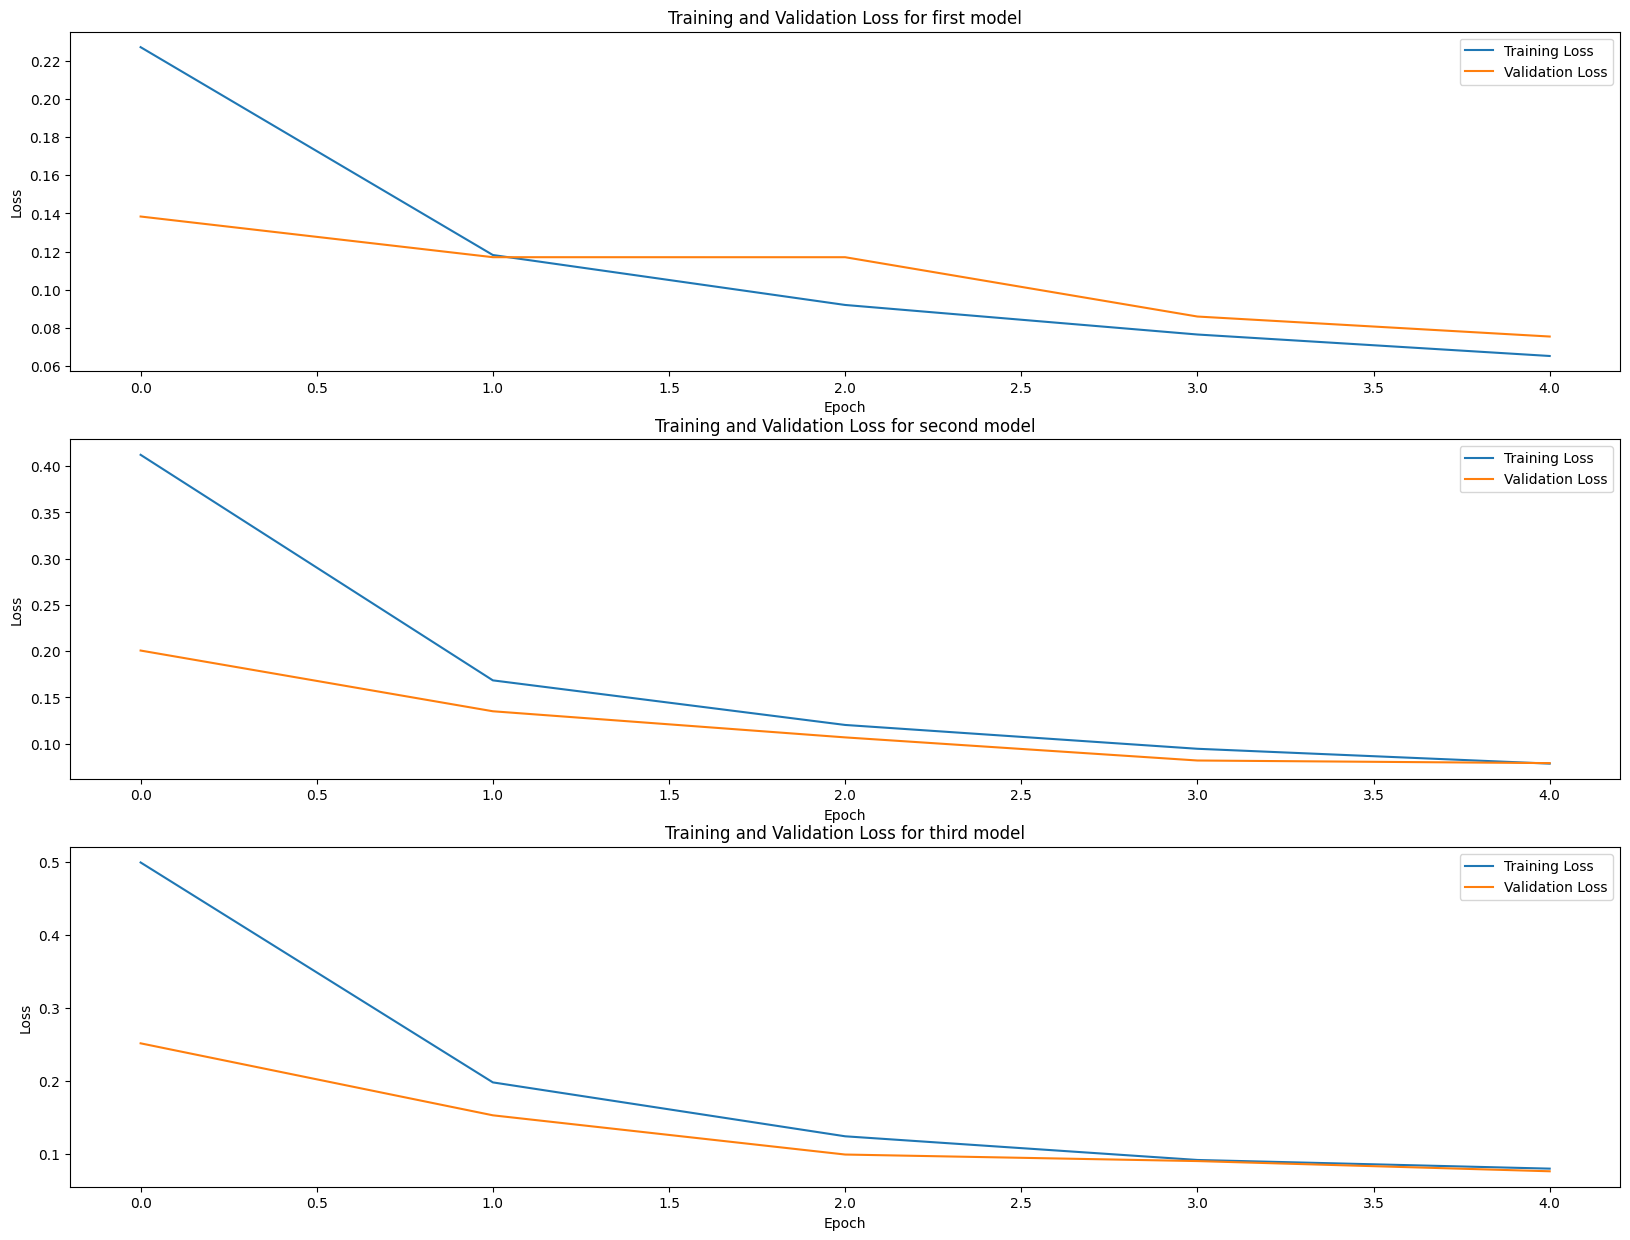

In [36]:
# Create a figure with subplots
plt.figure(figsize=(20, 15))

# Loss
plt.subplot(3, 1, 1)
plt.plot(historyFirst.history['loss'], label='Training Loss')
plt.plot(historyFirst.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for first model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(historySecond.history['loss'], label='Training Loss')
plt.plot(historySecond.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for second model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(historyThird.history['loss'], label='Training Loss')
plt.plot(historyThird.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for third model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

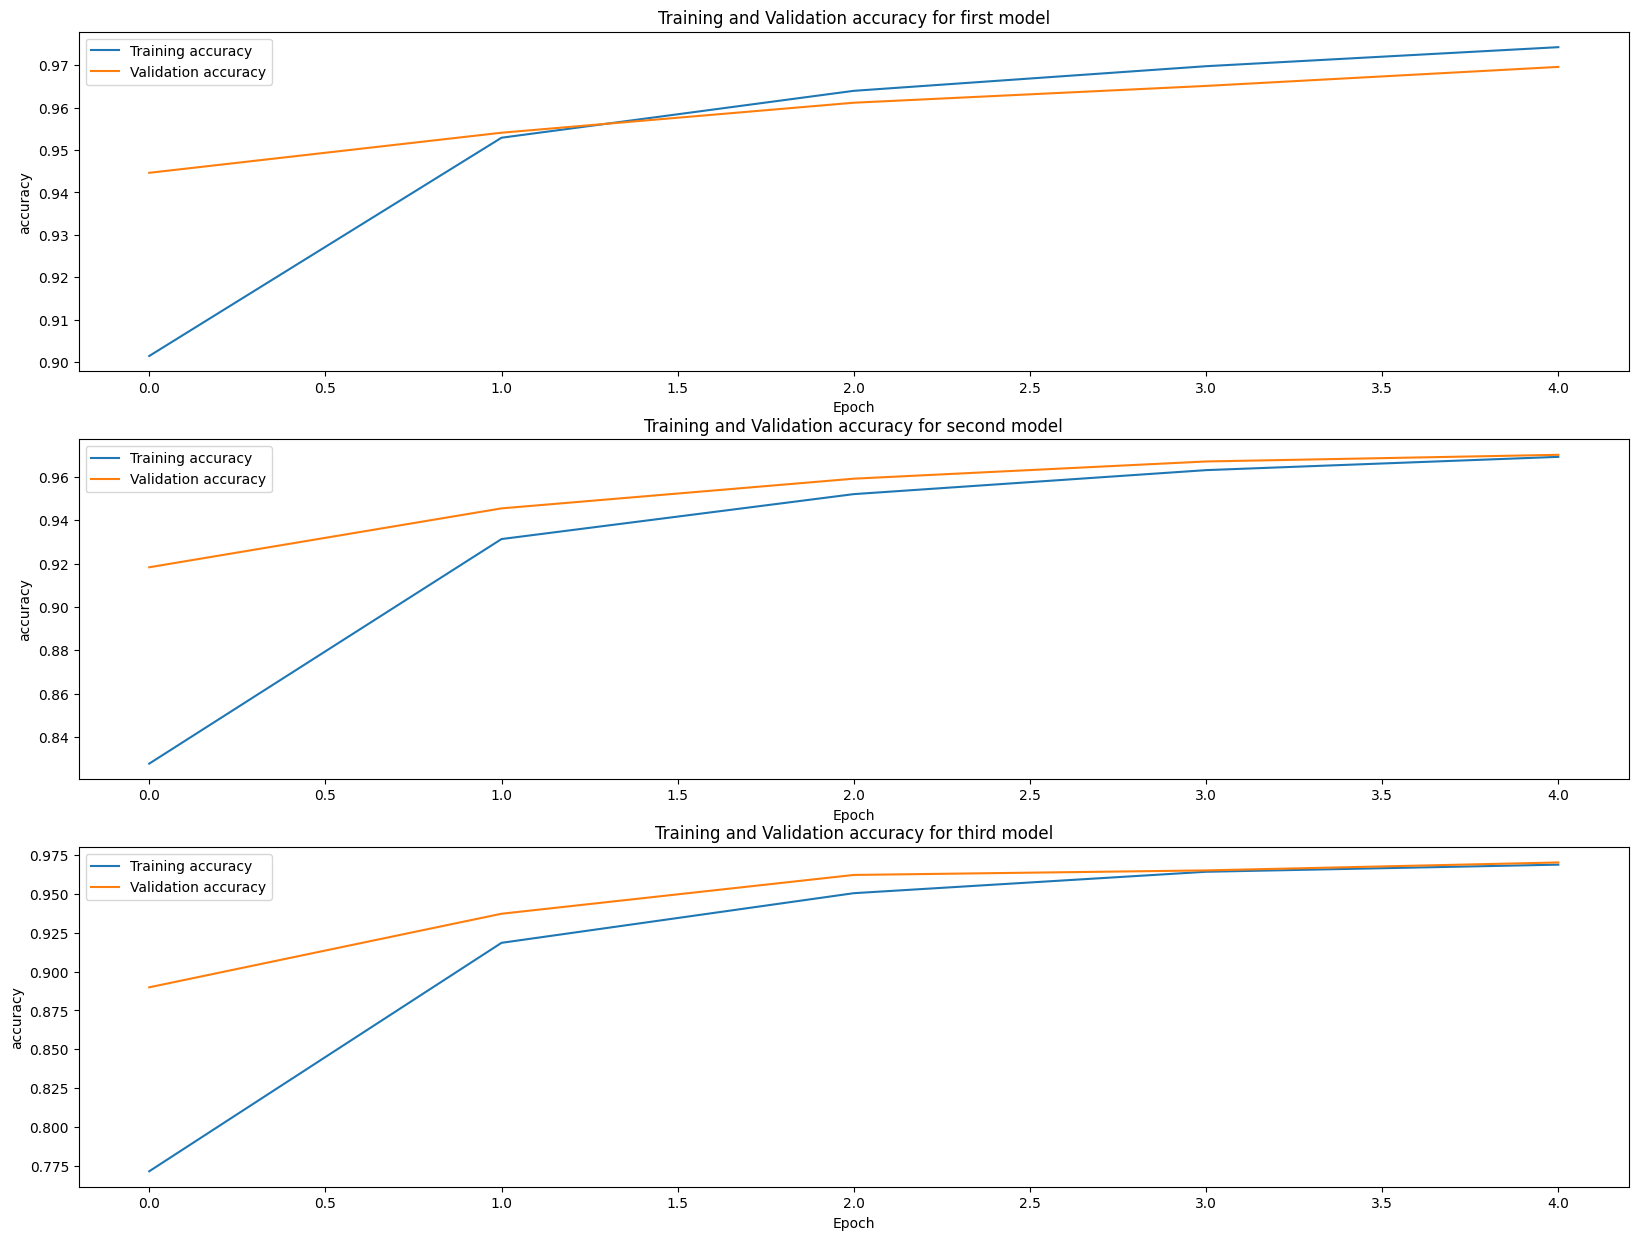

In [37]:
# Create a figure with subplots
plt.figure(figsize=(20, 15))

# accuracy
plt.subplot(3, 1, 1)
plt.plot(historyFirst.history['accuracy'], label='Training accuracy')
plt.plot(historyFirst.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy for first model')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(historySecond.history['accuracy'], label='Training accuracy')
plt.plot(historySecond.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy for second model')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(historyThird.history['accuracy'], label='Training accuracy')
plt.plot(historyThird.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy for third model')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

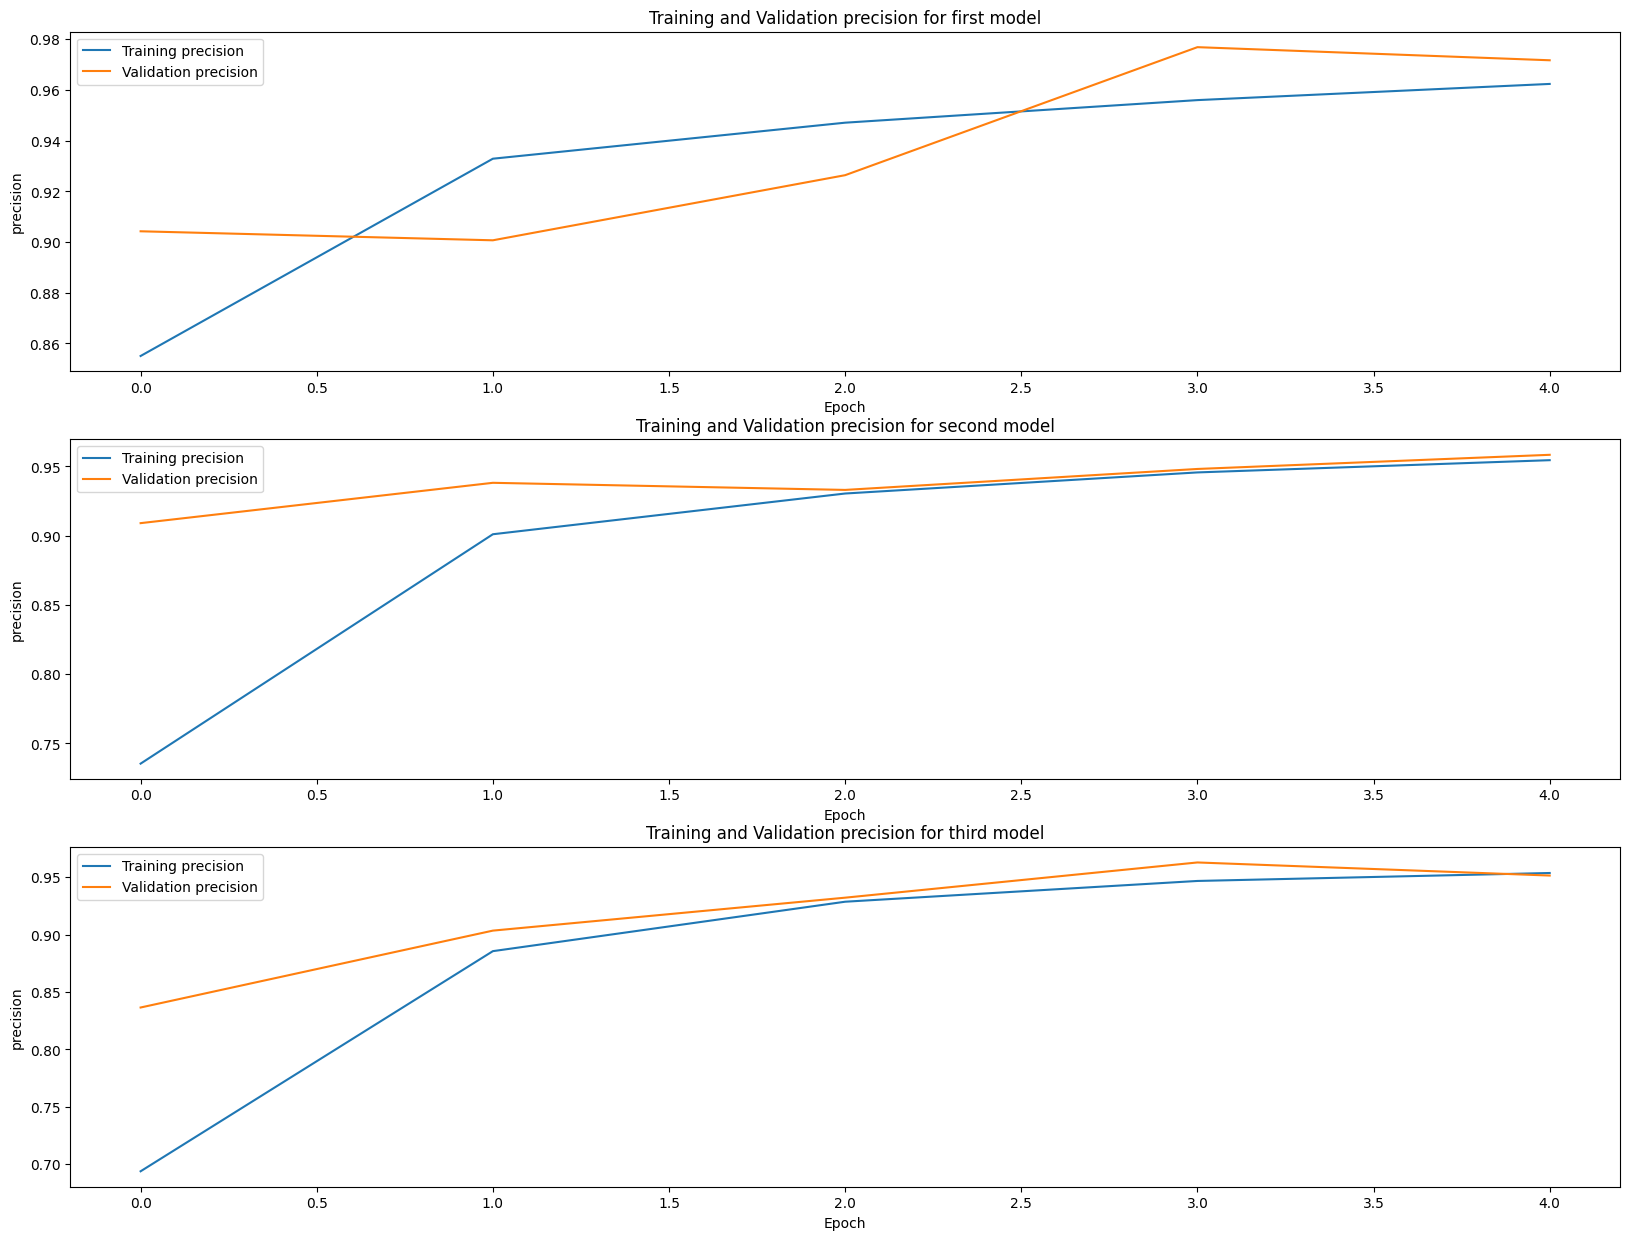

In [38]:
# Create a figure with subplots
plt.figure(figsize=(20, 15))

# precision
plt.subplot(3, 1, 1)
plt.plot(historyFirst.history['precision'], label='Training precision')
plt.plot(historyFirst.history['val_precision'], label='Validation precision')
plt.title('Training and Validation precision for first model')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(historySecond.history['precision'], label='Training precision')
plt.plot(historySecond.history['val_precision'], label='Validation precision')
plt.title('Training and Validation precision for second model')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(historyThird.history['precision'], label='Training precision')
plt.plot(historyThird.history['val_precision'], label='Validation precision')
plt.title('Training and Validation precision for third model')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.show()

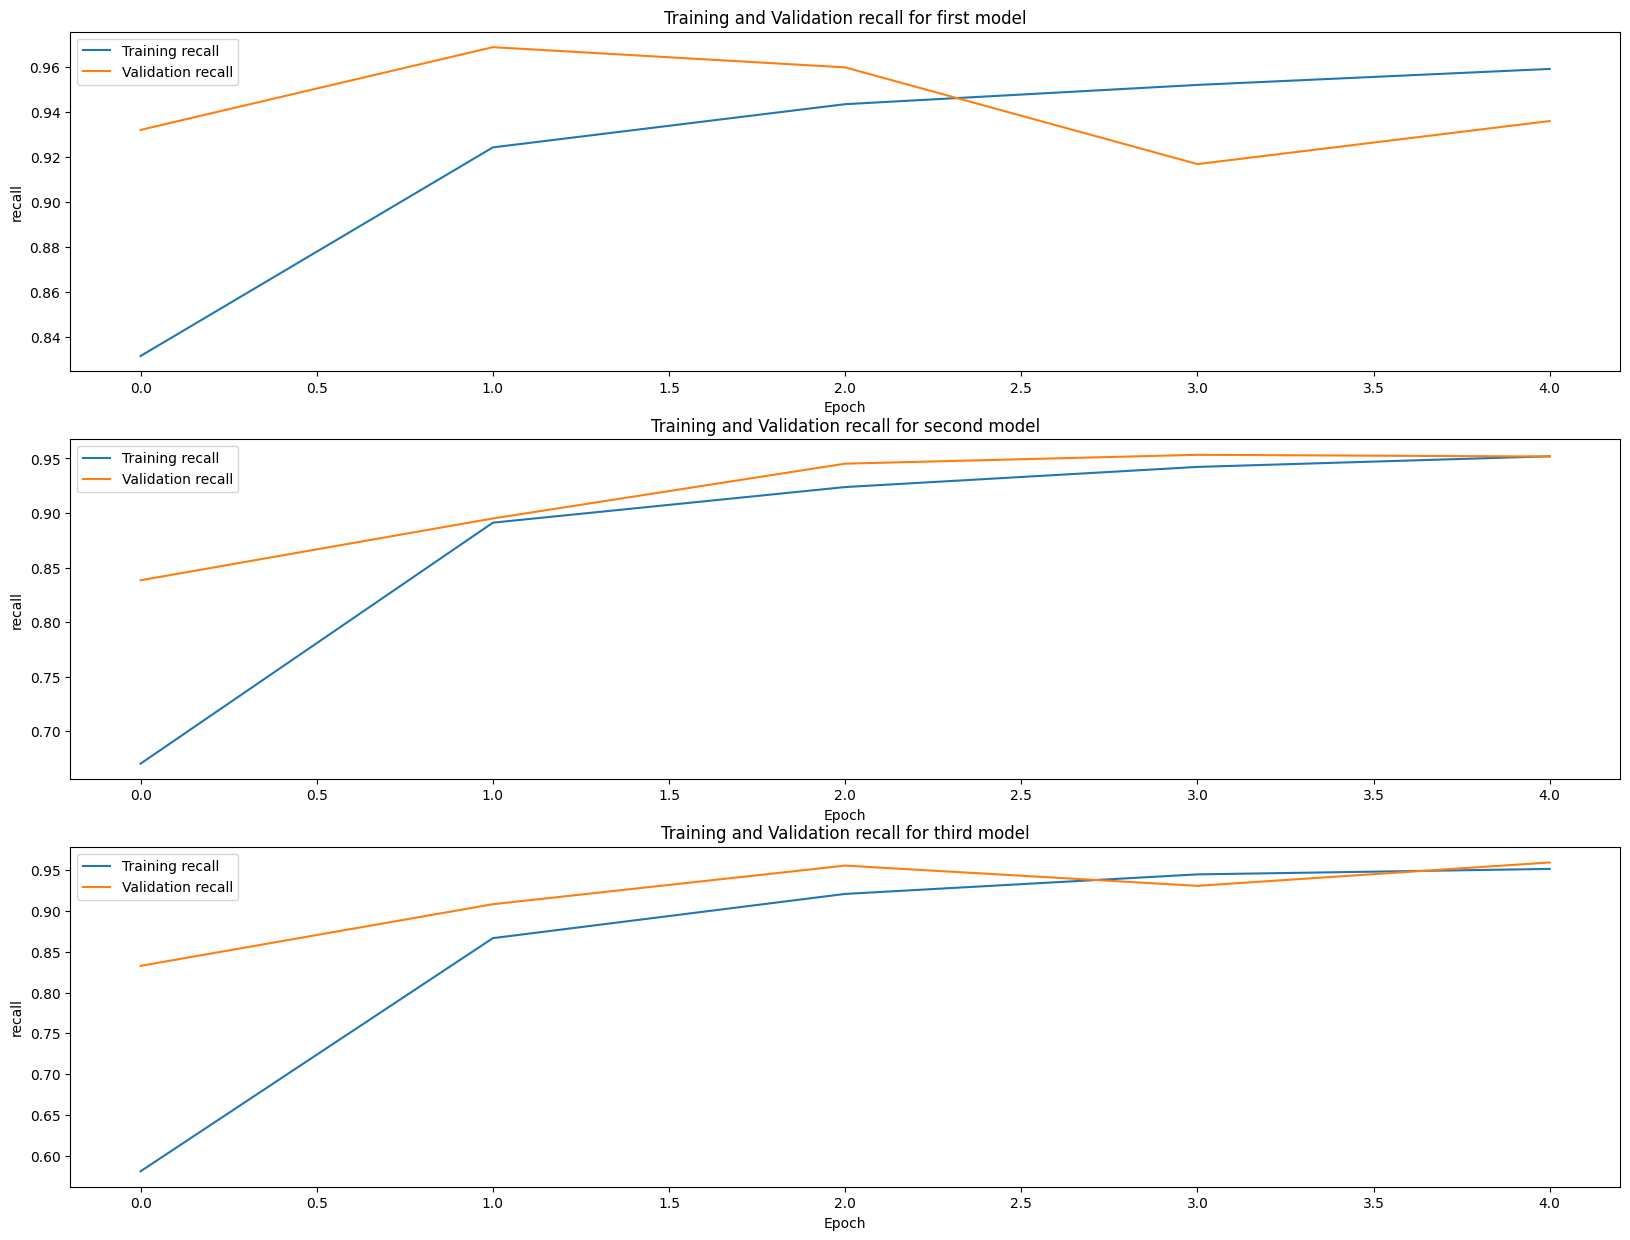

In [41]:
# Create a figure with subplots
plt.figure(figsize=(20, 15))

# recall
plt.subplot(3, 1, 1)
plt.plot(historyFirst.history['recall'], label='Training recall')
plt.plot(historyFirst.history['val_recall'], label='Validation recall')
plt.title('Training and Validation recall for first model')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(historySecond.history['recall'], label='Training recall')
plt.plot(historySecond.history['val_recall'], label='Validation recall')
plt.title('Training and Validation recall for second model')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(historyThird.history['recall'], label='Training recall')
plt.plot(historyThird.history['val_recall'], label='Validation recall')
plt.title('Training and Validation recall for third model')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()

plt.show()

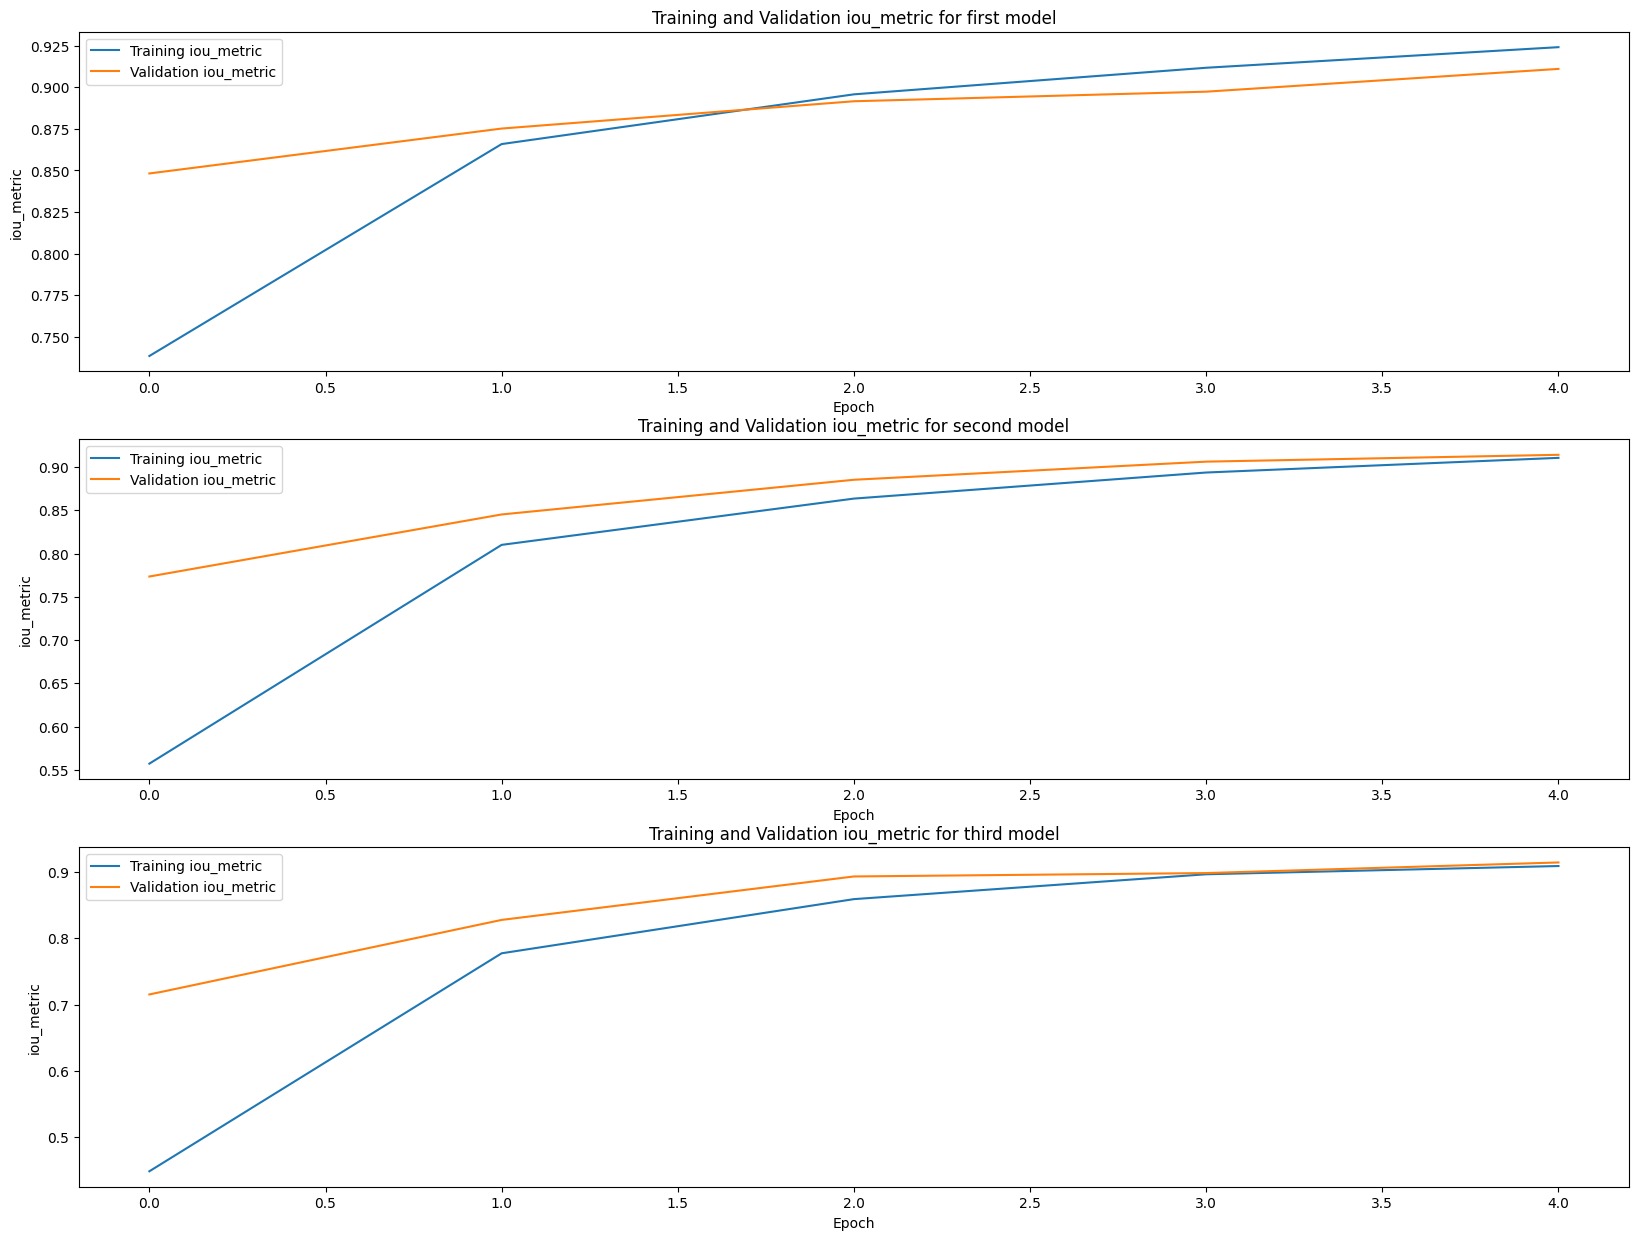

In [42]:
# Create a figure with subplots
plt.figure(figsize=(20, 15))

# iou_metric
plt.subplot(3, 1, 1)
plt.plot(historyFirst.history['iou_metric'], label='Training iou_metric')
plt.plot(historyFirst.history['val_iou_metric'], label='Validation iou_metric')
plt.title('Training and Validation iou_metric for first model')
plt.xlabel('Epoch')
plt.ylabel('iou_metric')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(historySecond.history['iou_metric'], label='Training iou_metric')
plt.plot(historySecond.history['val_iou_metric'], label='Validation iou_metric')
plt.title('Training and Validation iou_metric for second model')
plt.xlabel('Epoch')
plt.ylabel('iou_metric')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(historyThird.history['iou_metric'], label='Training iou_metric')
plt.plot(historyThird.history['val_iou_metric'], label='Validation iou_metric')
plt.title('Training and Validation iou_metric for third model')
plt.xlabel('Epoch')
plt.ylabel('iou_metric')
plt.legend()

plt.show()

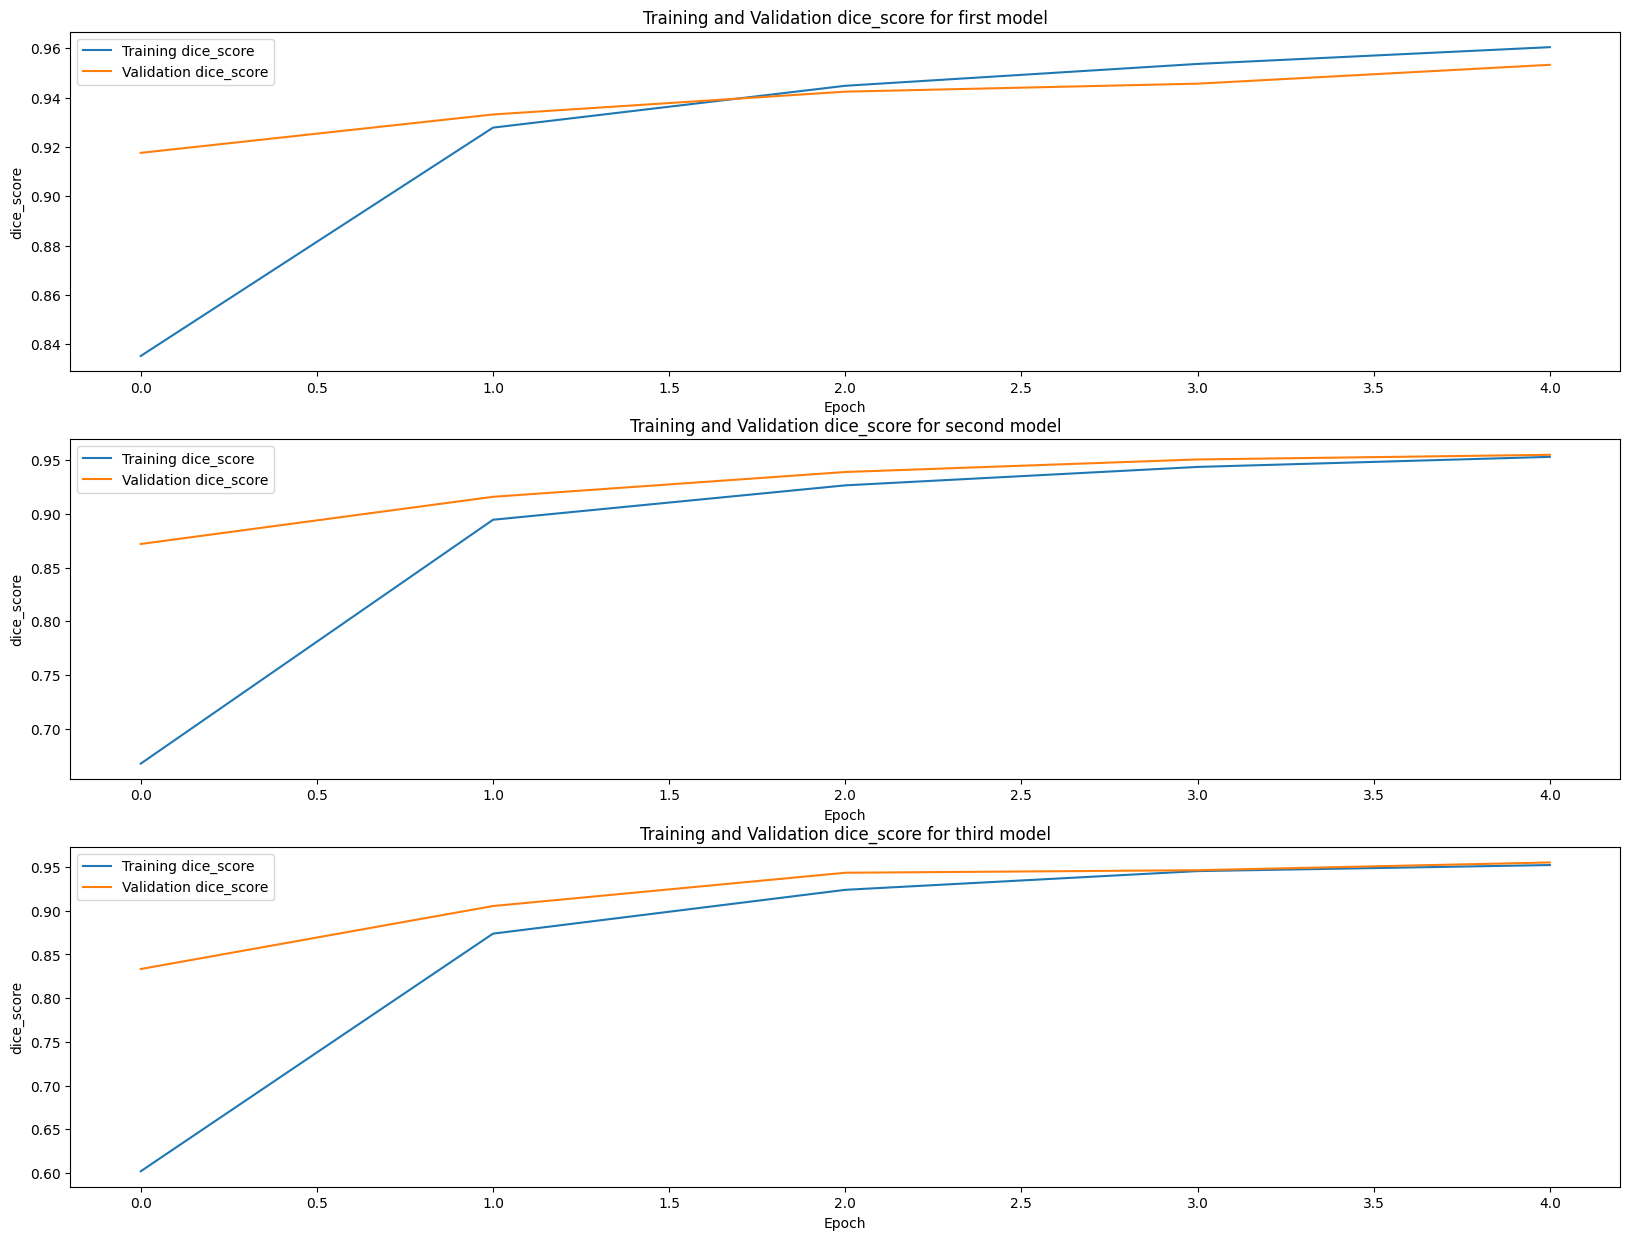

In [43]:
# Create a figure with subplots
plt.figure(figsize=(20, 15))

# dice_score
plt.subplot(3, 1, 1)
plt.plot(historyFirst.history['dice_score'], label='Training dice_score')
plt.plot(historyFirst.history['val_dice_score'], label='Validation dice_score')
plt.title('Training and Validation dice_score for first model')
plt.xlabel('Epoch')
plt.ylabel('dice_score')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(historySecond.history['dice_score'], label='Training dice_score')
plt.plot(historySecond.history['val_dice_score'], label='Validation dice_score')
plt.title('Training and Validation dice_score for second model')
plt.xlabel('Epoch')
plt.ylabel('dice_score')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(historyThird.history['dice_score'], label='Training dice_score')
plt.plot(historyThird.history['val_dice_score'], label='Validation dice_score')
plt.title('Training and Validation dice_score for third model')
plt.xlabel('Epoch')
plt.ylabel('dice_score')
plt.legend()

plt.show()

In [46]:
# Verify X_test shape
print(f"X_test shape: {X_test.shape}")

# Predict in batches to match the model's expected batch size
batch_size = 16
yPredFirst = []

for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i + batch_size]
    yPredFirstBatch = modelFirst.predict(batch)
    yPredFirst.append(yPredFirstBatch)

# Concatenate predictions
yPredFirst = np.concatenate(yPredFirst, axis=0)

# Binarize predictions
yPredFirst_binary = (yPredFirst > 0.5).astype(np.float32)

# Compute metrics on the test data
test_iou = iou_metric(y_test, yPredFirst_binary).numpy()
test_dice = dice_score(y_test, yPredFirst_binary).numpy()
test_precision = precision(y_test, yPredFirst_binary).numpy()
test_recall = recall(y_test, yPredFirst_binary).numpy()
test_accuracy = accuracy(y_test, yPredFirst_binary).numpy()

print(f"Test IoU: {test_iou:.4f}")
print(f"Test Dice Score: {test_dice:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

X_test shape: (1877, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 84

In [47]:
# Verify X_test shape
print(f"X_test shape: {X_test.shape}")

# Predict in batches to match the model's expected batch size
batch_size = 32
yPredSecond = []

for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i + batch_size]
    yPredSecondBatch = modelSecond.predict(batch)
    yPredSecond.append(yPredSecondBatch)

# Concatenate predictions
yPredSecond = np.concatenate(yPredSecond, axis=0)

# Binarize predictions
yPredSecond_binary = (yPredSecond > 0.5).astype(np.float32)

# Compute metrics on the test data
test_iou = iou_metric(y_test, yPredSecond_binary).numpy()
test_dice = dice_score(y_test, yPredSecond_binary).numpy()
test_precision = precision(y_test, yPredSecond_binary).numpy()
test_recall = recall(y_test, yPredSecond_binary).numpy()
test_accuracy = accuracy(y_test, yPredSecond_binary).numpy()

print(f"Test IoU: {test_iou:.4f}")
print(f"Test Dice Score: {test_dice:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

X_test shape: (1877, 128, 128, 3)


c:\Users\rog\anaconda3\envs\MLTutorial\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_254']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [48]:
# Verify X_test shape
print(f"X_test shape: {X_test.shape}")

# Predict in batches to match the model's expected batch size
batch_size = 16
yPredThird = []

for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i + batch_size]
    yPredThirdBatch = modelThird.predict(batch)
    yPredThird.append(yPredThirdBatch)

# Concatenate predictions
yPredThird = np.concatenate(yPredThird, axis=0)

# Binarize predictions
yPredThird_binary = (yPredThird > 0.5).astype(np.float32)

# Compute metrics on the test data
test_iou = iou_metric(y_test, yPredThird_binary).numpy()
test_dice = dice_score(y_test, yPredThird_binary).numpy()
test_precision = precision(y_test, yPredThird_binary).numpy()
test_recall = recall(y_test, yPredThird_binary).numpy()
test_accuracy = accuracy(y_test, yPredThird_binary).numpy()

print(f"Test IoU: {test_iou:.4f}")
print(f"Test Dice Score: {test_dice:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

X_test shape: (1877, 128, 128, 3)


c:\Users\rog\anaconda3\envs\MLTutorial\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_286']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

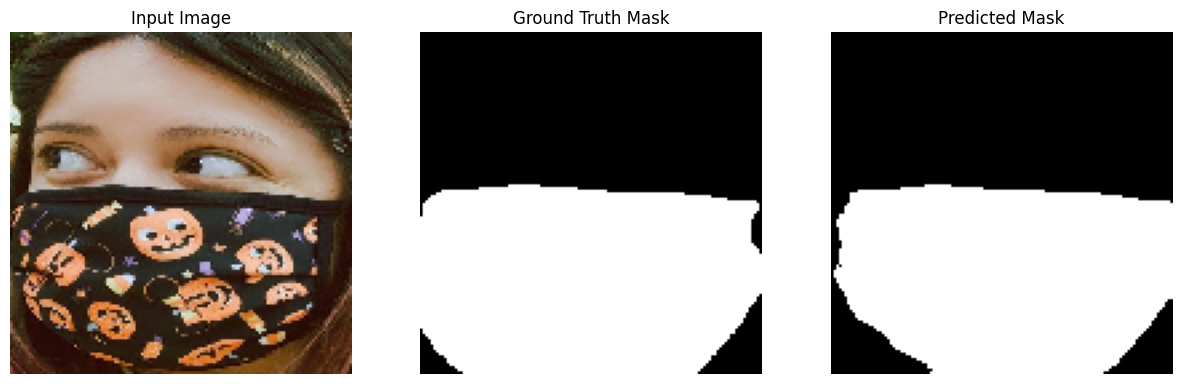

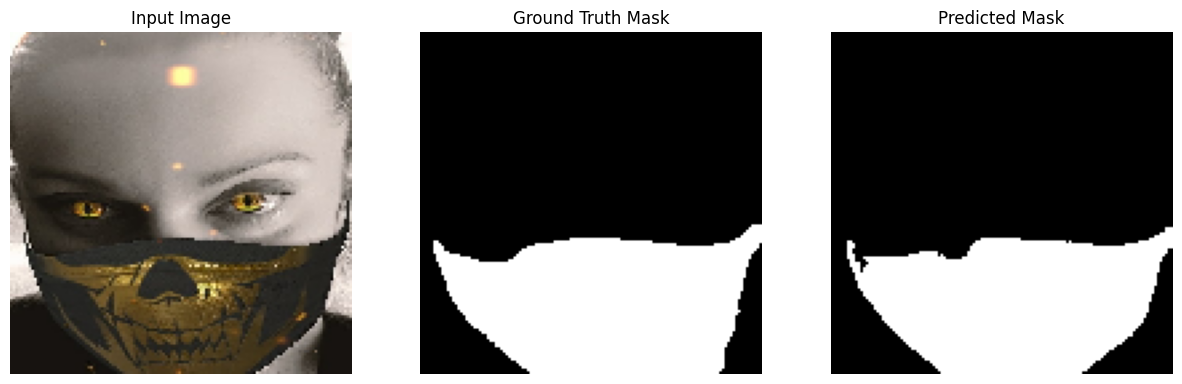

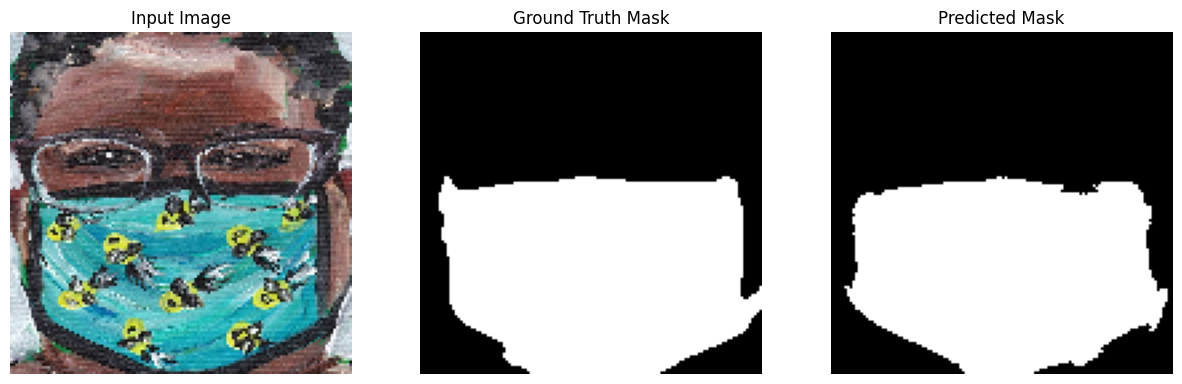

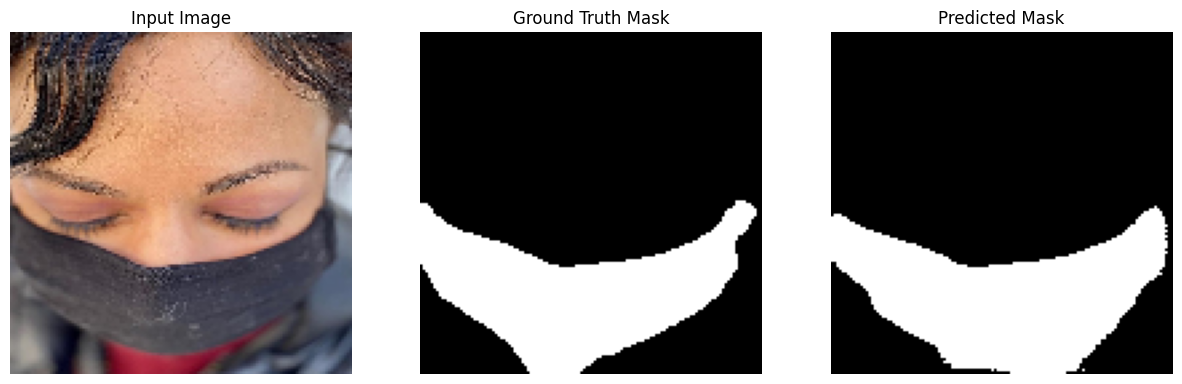

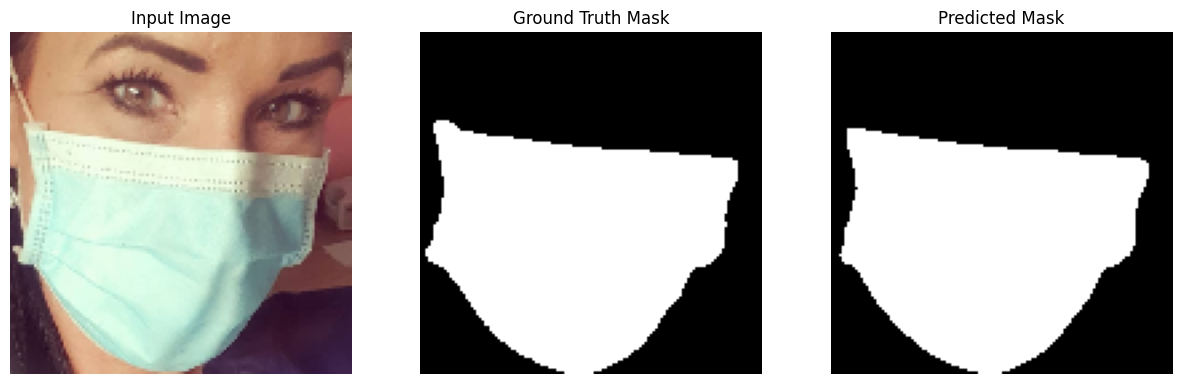

In [ ]:

def display_results(image, ground_truth, prediction, index):
    plt.figure(figsize=(15, 5))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(image[index])
    plt.title("Input Image")
    plt.axis('off')

    # Display ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(ground_truth[index]), cmap='gray')  # Use tf.squeeze
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(prediction[index]), cmap='gray')  # Use tf.squeeze
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

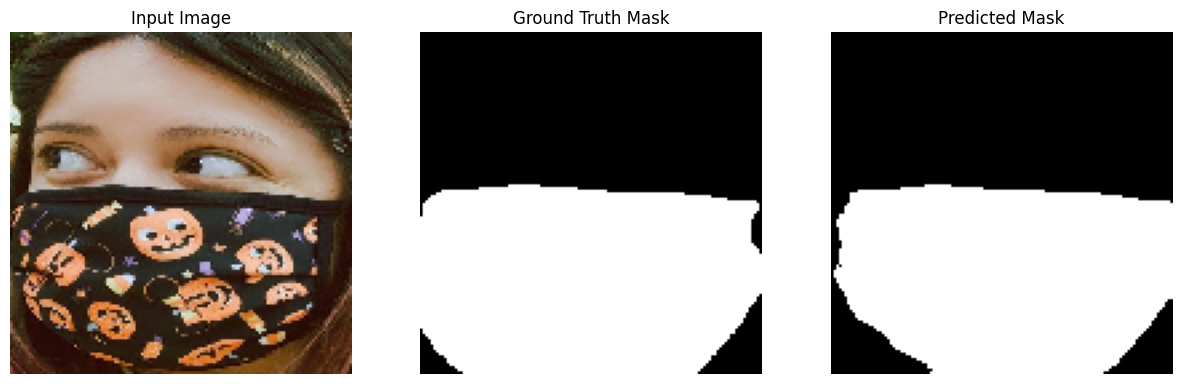

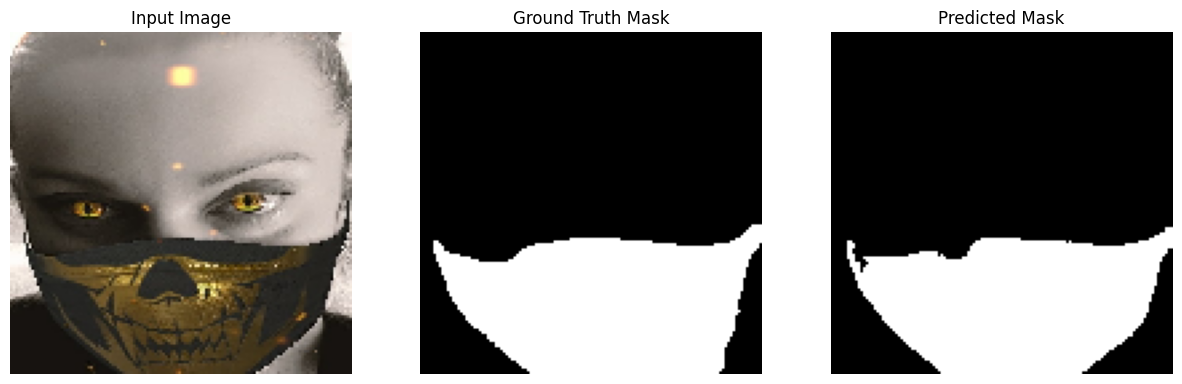

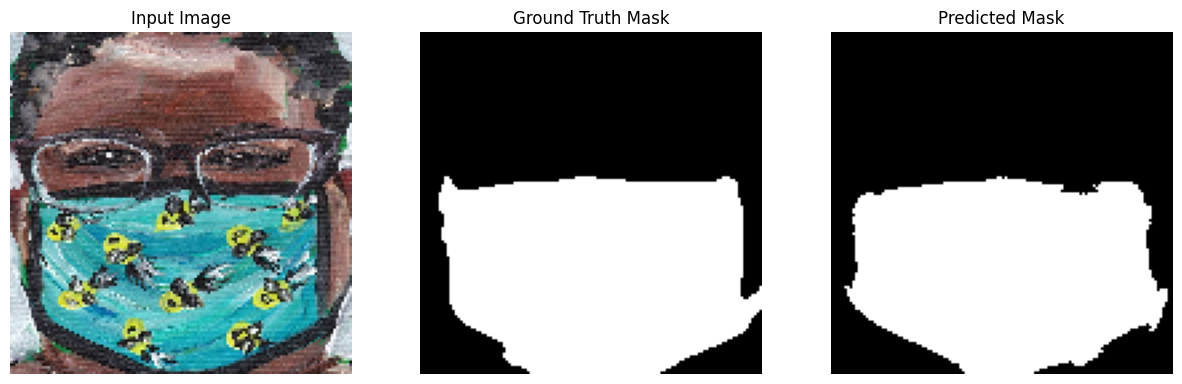

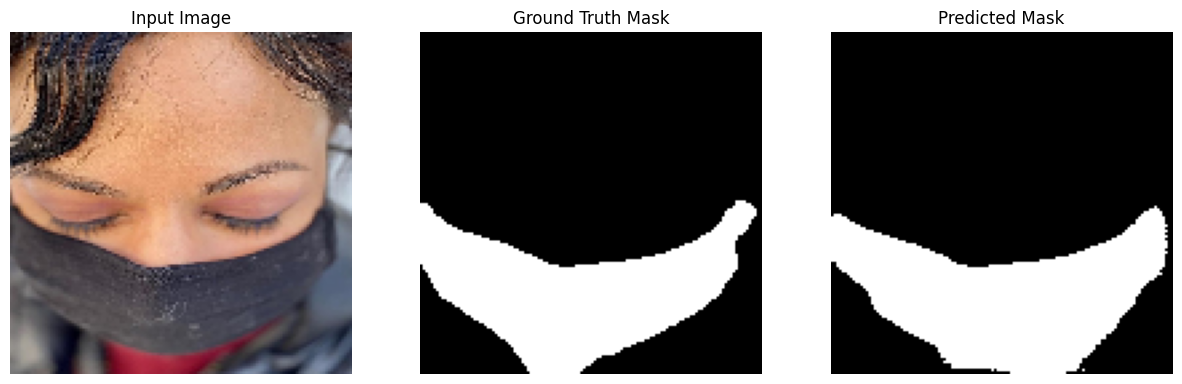

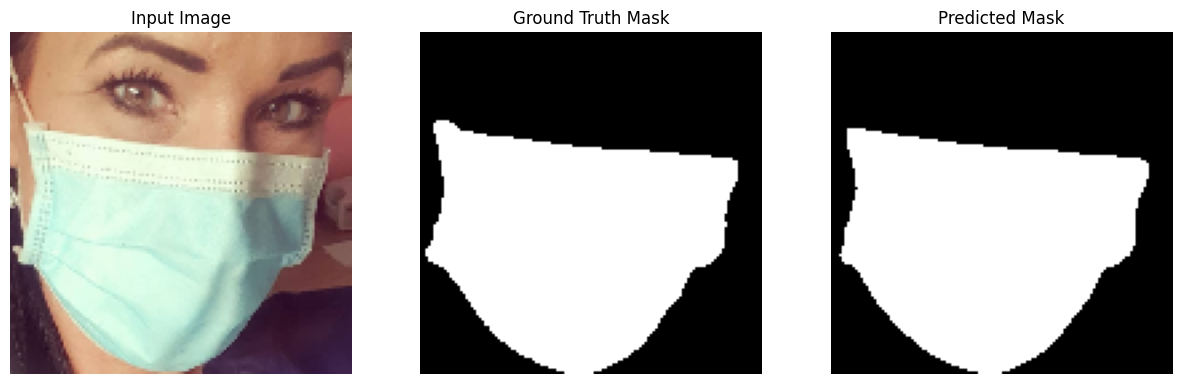

In [52]:
# Display results for a few test samples
num_samples_to_display = 5  # Number of samples to visualize
for i in range(num_samples_to_display):
    display_results(X_test, y_test, yPredFirst_binary, i)

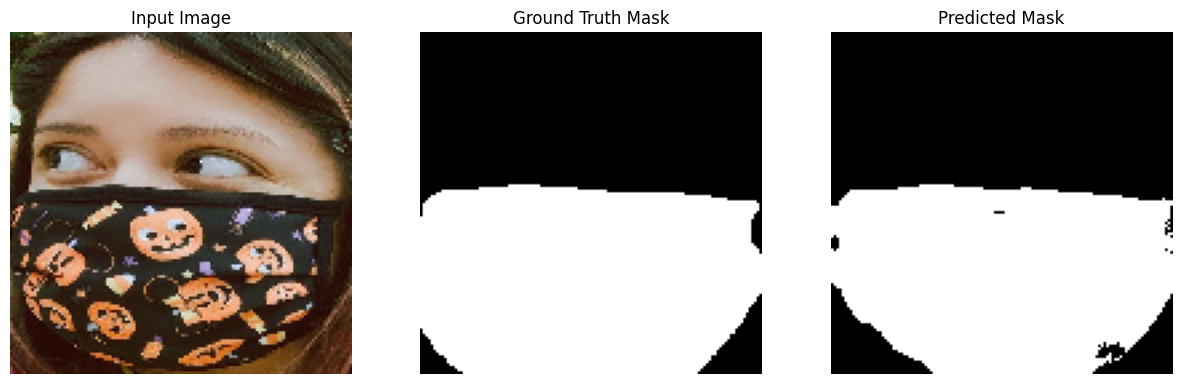

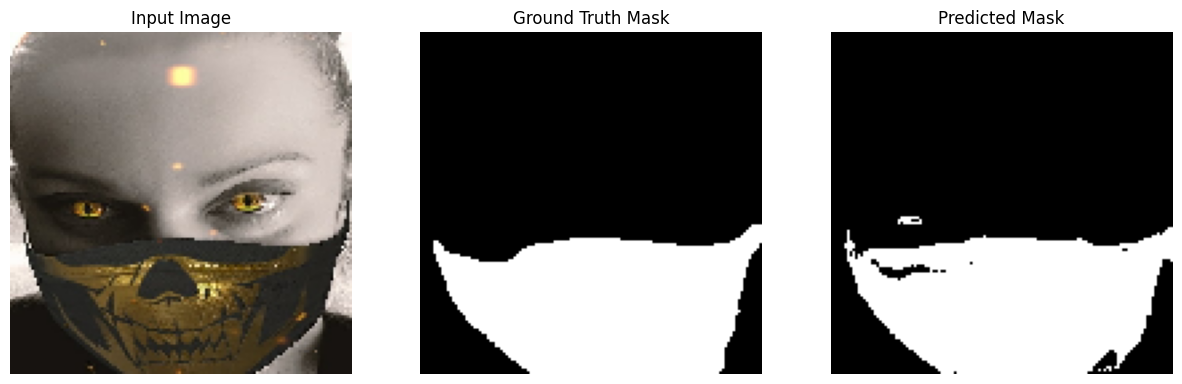

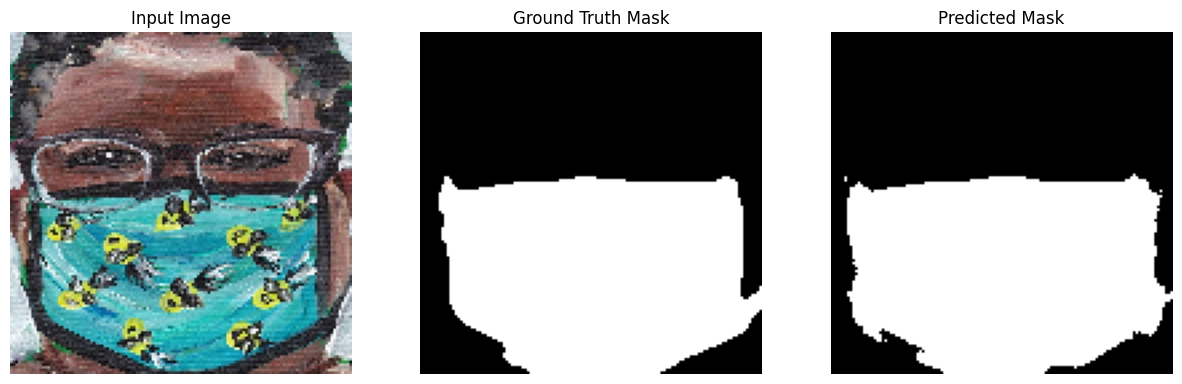

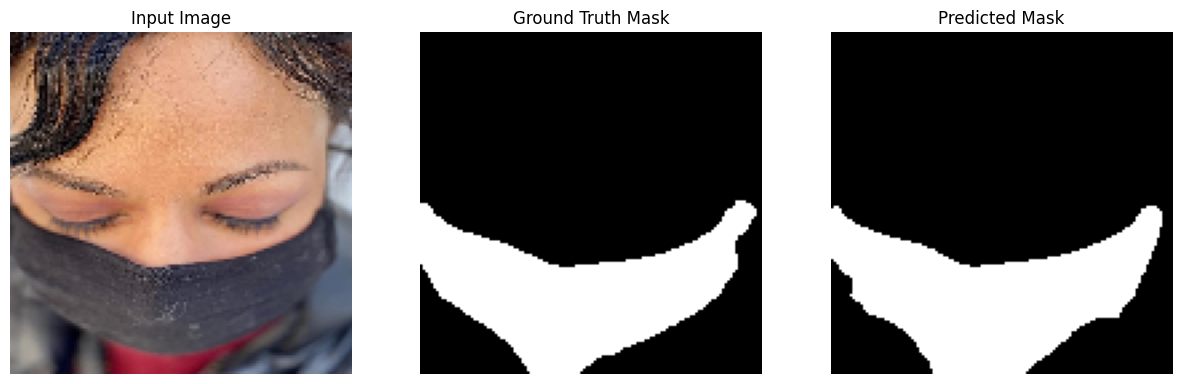

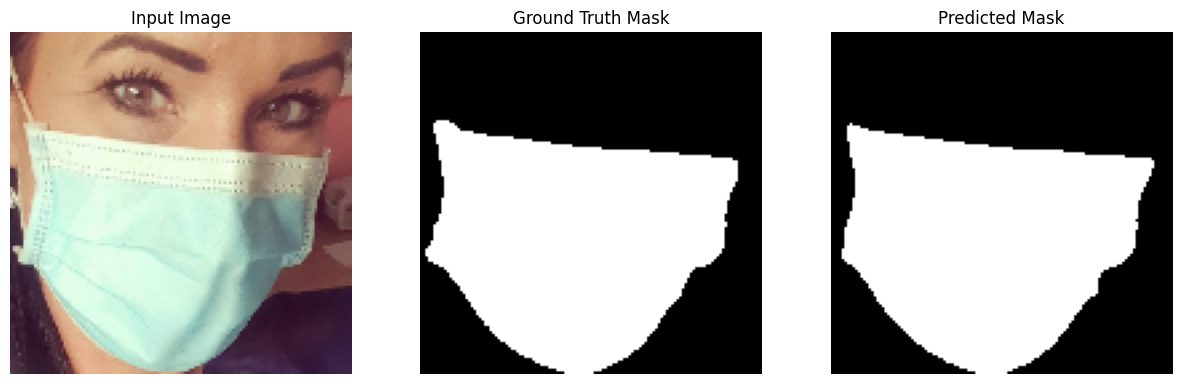

In [53]:

for i in range(num_samples_to_display):
    display_results(X_test, y_test, yPredSecond_binary, i)

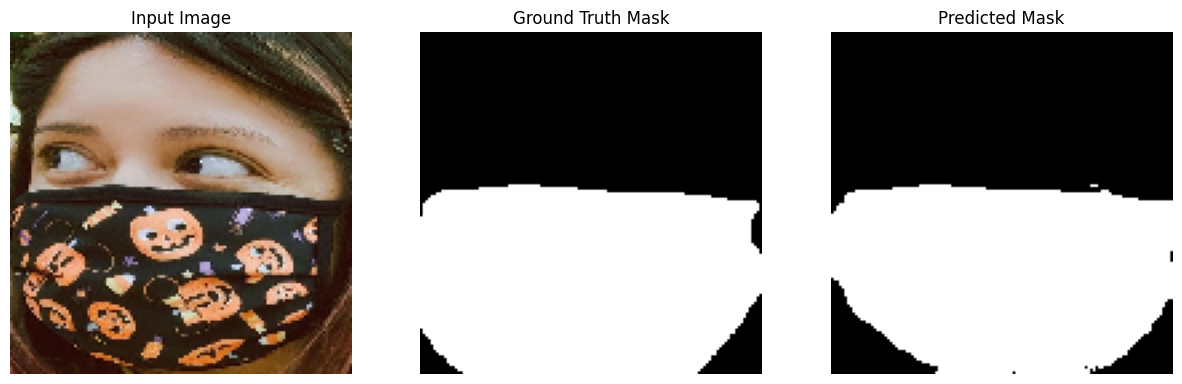

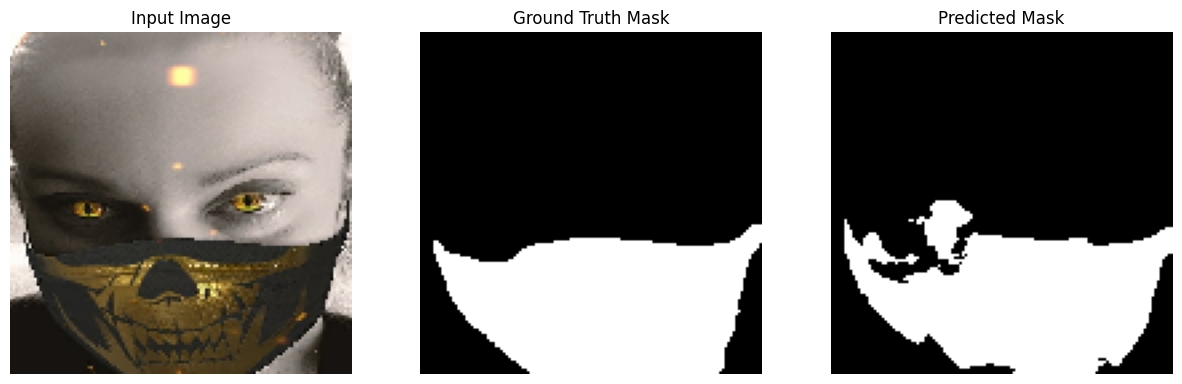

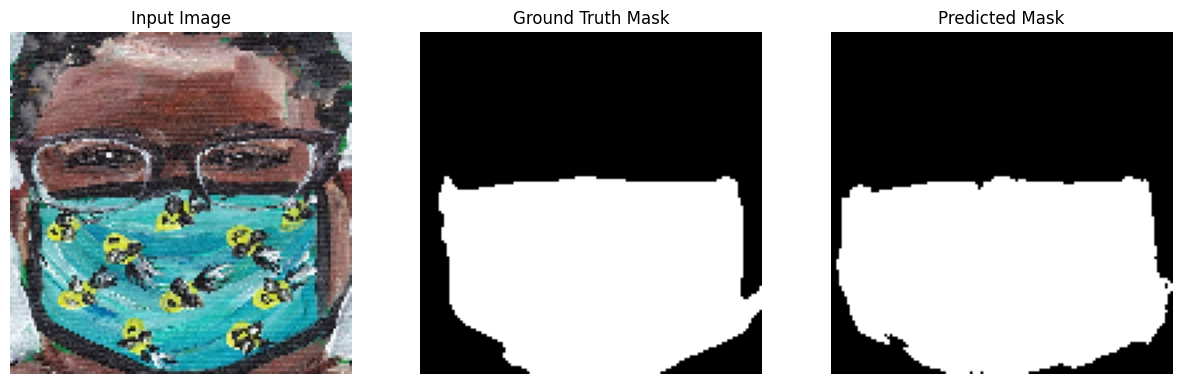

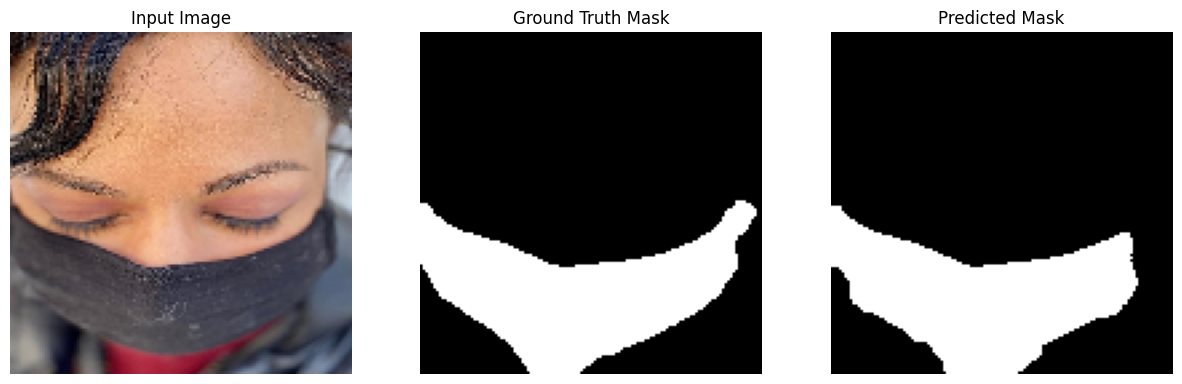

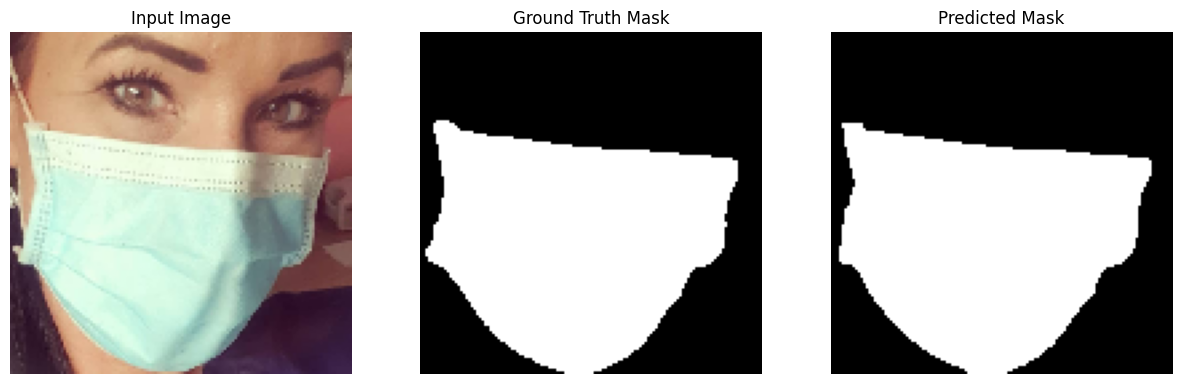

In [ ]:
for i in range(num_samples_to_display):
    display_results(X_test, y_test, yPredThird_binary, i)